In [1]:
#import packages
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import requests
import configparser
import pickle
import string
import nltk
from copy import deepcopy
import random 

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer

#modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve

#pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve


import time
import collections
from PIL import Image
import sys

from datetime import datetime, timedelta, date


# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.max()

login_time   1970-04-13 18:57:38
dtype: datetime64[ns]

In [4]:
logins.min()

login_time   1970-01-01 20:12:16
dtype: datetime64[ns]

In [5]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
def assign_15m(tm):
    bucket = tm - timedelta(minutes=tm.minute % 15,
                             seconds=tm.second,
                             microseconds=tm.microsecond)
    return bucket.time()

logins['date'] = logins['login_time'].apply(lambda x: x.date())
logins['month'] = logins['login_time'].apply(lambda x: x.month)
logins['day'] = logins['login_time'].apply(lambda x: x.day)
logins['15m_bucket'] = logins['login_time'].apply(assign_15m)
logins['hour'] = logins['login_time'].apply(lambda x: x.hour)
logins['weekday'] = logins['login_time'].apply(lambda x: x.weekday())

In [7]:
logins.head(20)

,login_time,date,month,day,15m_bucket,hour,weekday
0,1970-01-01 20:13:18,1970-01-01,1,1,20:00:00,20,3
1,1970-01-01 20:16:10,1970-01-01,1,1,20:15:00,20,3
2,1970-01-01 20:16:37,1970-01-01,1,1,20:15:00,20,3
3,1970-01-01 20:16:36,1970-01-01,1,1,20:15:00,20,3
4,1970-01-01 20:26:21,1970-01-01,1,1,20:15:00,20,3
5,1970-01-01 20:21:41,1970-01-01,1,1,20:15:00,20,3
6,1970-01-01 20:12:16,1970-01-01,1,1,20:00:00,20,3
7,1970-01-01 20:35:47,1970-01-01,1,1,20:30:00,20,3
8,1970-01-01 20:35:38,1970-01-01,1,1,20:30:00,20,3
9,1970-01-01 20:47:52,1970-01-01,1,1,20:45:00,20,3


Text(0.5,1,'Rides per 15m increment')

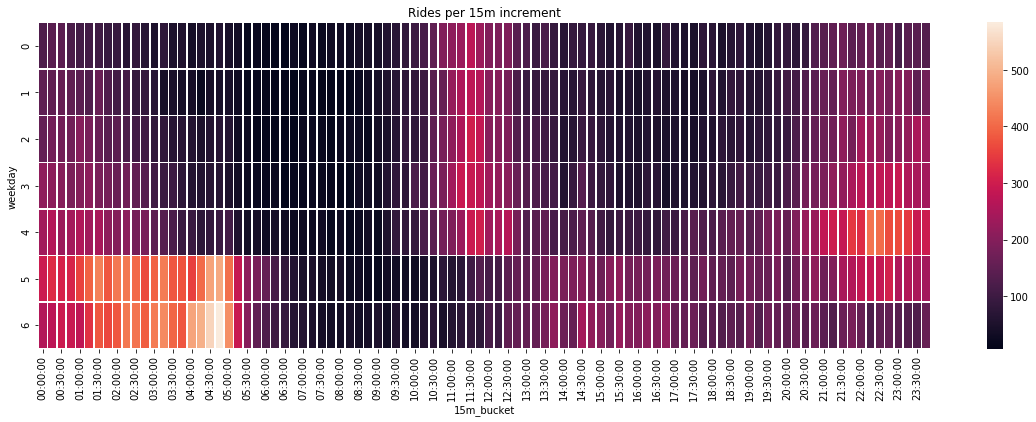

In [8]:
#rides per 15m increment
trial = (logins.groupby(['weekday', '15m_bucket']).size()).to_frame().reset_index()
trial = trial.rename(columns={0:'total'})
trial = trial.pivot("weekday", "15m_bucket", "total")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(trial, annot=False, linewidths=.5, fmt=".0f", ax=ax)
plt.title('Rides per 15m increment')

Text(0.5,1,'Rides per day')

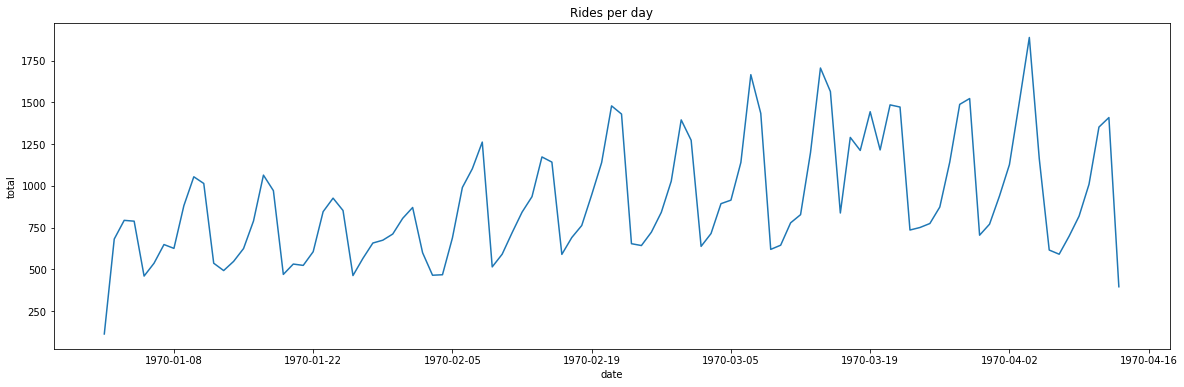

In [9]:
#rides per day
trial = (logins.groupby(['date']).size()).to_frame().reset_index()
trial = trial.rename(columns={0:'total'})

f, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(x = 'date', y = 'total', data = trial, ax = ax)
plt.title('Rides per day')

Text(0.5,1,'Rides per 15m increment 3/15 - 3/21')

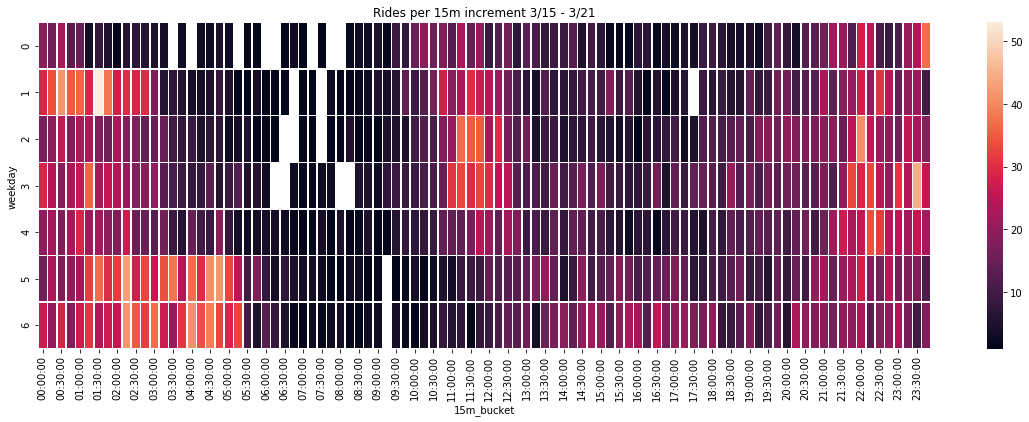

In [10]:
subsample = logins[(logins['date'] > date(1970, 3, 14)) & (logins['date'] < date(1970, 3, 22))]

#rides per day
trial = (subsample.groupby(['weekday', '15m_bucket']).size()).to_frame().reset_index()
trial = trial.rename(columns={0:'total'})
trial = trial.pivot("weekday", "15m_bucket", "total")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(trial, annot=False, linewidths=.5, fmt=".0f", ax=ax)
plt.title('Rides per 15m increment 3/15 - 3/21')

As expected there are different demand patterns between weekday and weekend time periods.  For a weekday, the highest demand is during the 11:00 - 12:30 period. For a weekend, the highest demand is during the evening and early morning hours.  This suggests that users generally use the service for entertainment purposes - going to lunch during the weekday and going out during the weekend.  

There was one anomalous period during March 14-22 where user activity did not follow the typical weekly patterns.  There was constantly high user activity during both weekdays and weekends.  During this period, the weekday early mornings and late evenings were uncharacteristally very active in addition to the miday period.  This could indicate a data quality issue or an unusual phenomenon (ie: holidays or festivals).


# Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
<br>
a. how you will implement the experiment
<br>
b. what statistical test(s) you will conduct to verify the significance of the
observation
<br>
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


<b> Metric </b>
<br>
The key metric of success is the proportion of drivers sessions with dual-city activity during the weekend.  Dual city activity is defined as having a drop off or pickup in both cities. This metric is specific to the weekend because there is demand in both cities during the same time so a driver would have the choice to cross the bridge to help riders in either city.  A driver session could be defined as continuous period of driver activity of resonable length where a driver would reasonably be expected to field multiple requests from both cities (ie: a period of 2 or more hours).


This metric captures the intended outcome - driver availibilty in both cities, and is specific to the driver sessions where we are interested seeing dual-city activity.


<b> Experiemnt </b>

<i> Implementation </i>
<br>
I would identify a set of drivers working on a given weekend.  I would assign a subset of these drivers to an intervention group who would be reimbursed for all toll costs.  I would then calculate the percent of driver sessions with dual-city activity among both groups.

<i> Statistics </i>
<br>
To compare the percent of driver sessions with dual-city activity among both groups, I would use a two-proportion z test.  The null hypothesis of this test is that the proportions of driver sessions with dual-city activity are the same in both groups.  The alternative hypothesis is that the proportion in the intervention group is larger than the proportion in the control group.

<i> Interpretation </i>
<br>
If the intervention group has a higher proportion of dual-city driver sessions, I would recommend that the city operations could reimburse toll costs to increase availability in both cities.  However, this does not indicate that toll reimbursement is cost-effective or the best way increase dual-city activity.  Ostensibly, increasing dual-city activity would make supply of drivers more agile to meet demand for rides.  However, the cost of tolls reimbursement may be so high as to outweigh any benefit from balancing supply and demand.  A secondary metric to monitor is the number of rides that are fulfilled over the weekend.  If more riders are demanding and completing rides during the weekend due to toll reimbursement, this would provide stronger evidence in favor of the intervention.  

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json.

In [11]:
import json

with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

retention = pd.DataFrame(data)
retention.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [12]:
retention.shape

(50000, 12)

In [13]:
time_format = '%Y-%m-%d'
cols= ['last_trip_date', 'signup_date']
retention[cols]= (retention[cols].apply(pd.to_datetime, format=time_format))
retention['days_since_first'] = (retention.last_trip_date - retention.signup_date).apply(lambda x: x.days)
retention['retained'] = retention['days_since_first'].apply(lambda x: 1 if x > 150 else 0)
retention['ultimate_black_user'] = retention['ultimate_black_user']*1

#one hot encode cities
city_groups = pd.get_dummies(retention['city'], prefix='city', drop_first= True)
retention = pd.concat([retention, city_groups], axis =1)

#one hot encode cities
phone_groups = pd.get_dummies(retention['phone'], prefix='phone', drop_first= True)
retention = pd.concat([retention, phone_groups], axis =1)

In [14]:
retention.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
ultimate_black_user                int64
weekday_pct                      float64
days_since_first                   int64
retained                           int64
city_King's Landing                uint8
city_Winterfell                    uint8
phone_iPhone                       uint8
dtype: object

In [15]:
retention.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_since_first,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,143,0,1,0,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,96,0,0,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,170,1,1,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,47,0,0,1,0


## EDA

## What fraction of the observed users were retained?

6 month retention was defined as having a ride at least 150 days after initial sign up.  Per this definition, about 12K (24%) of 50K riders were retained.  
<br>
Univariate analysis shows that having a sign up city of Winterfell, using an iphone, and being an ultimate black user are strongly associated with 6 month retention. 

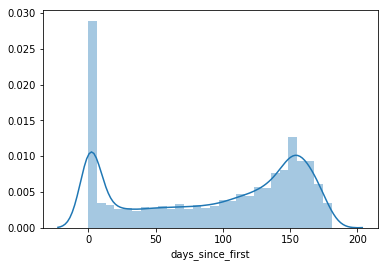

In [16]:
sns.distplot(retention['days_since_first'])

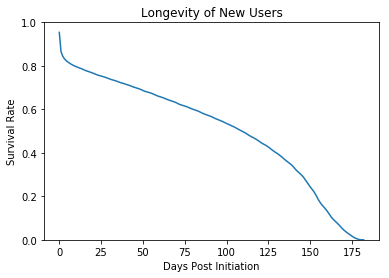

In [17]:
#survival curve
last = retention['days_since_first']

n_users = len(retention)
survivors = [1-(last == 0).sum()/len(last) ]
running_dropouts = (last == 0).sum()
for i in range(1,183):
    running_dropouts += (last == i).sum()
    surviving = (n_users-running_dropouts)/n_users
    survivors.append(surviving)

ax = sns.lineplot(x = range(0,183) , y = survivors, markers = '.')
ax.set_ylim([0, 1])
plt.title("Longevity of New Users")
plt.ylabel("Survival Rate")
plt.xlabel("Days Post Initiation")
plt.show()

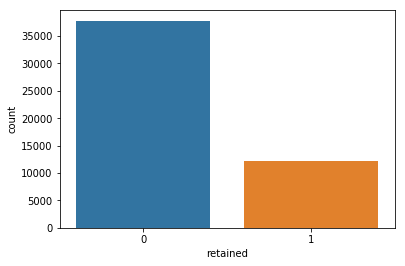

In [18]:
sns.countplot(x = 'retained', data = retention)

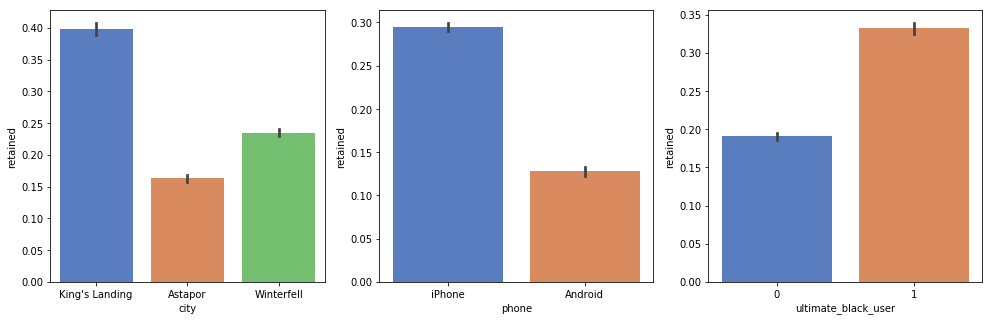

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize=(16.7, 5))

sns.catplot(ax = ax1, x="city", y="retained", data = retention, 
                   height=6, kind="bar", palette="muted")
sns.catplot(ax = ax2, x="phone", y="retained", data = retention, 
                   height=6, kind="bar", palette="muted")
sns.catplot(ax = ax3, x="ultimate_black_user", y="retained", data = retention, 
                   height=6, kind="bar", palette="muted")

plt.close(2)
plt.close(3)
plt.close(4)

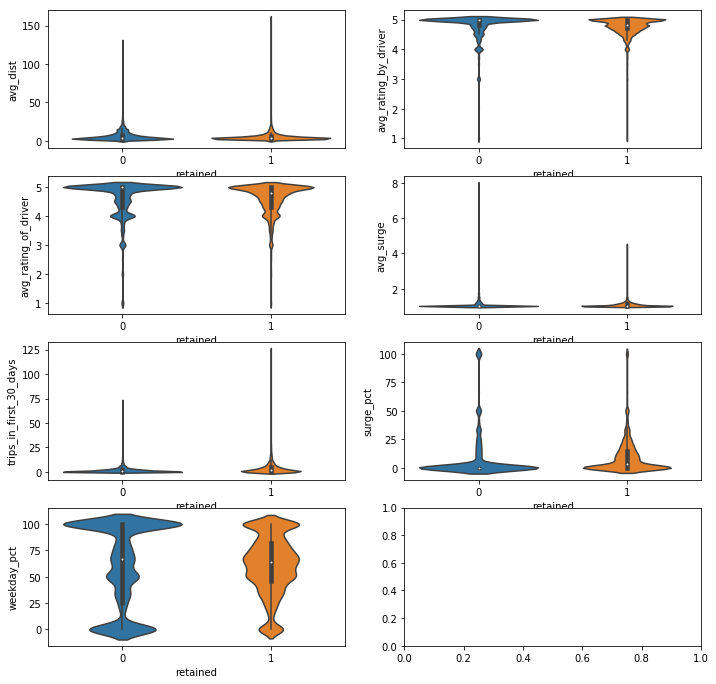

In [20]:
fig, axs = plt.subplots(nrows = 4, ncols = 2,figsize=(11.7, 11.7))

sns.violinplot(x="retained", y="avg_dist", data=retention, ax=axs[0,0])
sns.violinplot(x="retained", y="avg_rating_by_driver", data=retention, ax=axs[0,1])
sns.violinplot(x="retained", y="avg_rating_of_driver", data=retention, ax=axs[1,0])
sns.violinplot(x="retained", y="avg_surge", data=retention, ax=axs[1,1])
sns.violinplot(x="retained", y="trips_in_first_30_days", data=retention, ax=axs[2,0])
sns.violinplot(x="retained", y="surge_pct", data=retention, ax=axs[2,1])
sns.violinplot(x="retained", y="weekday_pct", data=retention, ax=axs[3,0])


## Build a Predictive Model

Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

I chose to use a logistic regression model.  This model has various advantages:
1. It is easily interpreted.
2. A quick grid search using the default parameters of alternative models (SVC, Random Forest, K-neighbors, and Adaboost) identified logistic regression as the best model

Hyperparameter tuning of a logistic regression generates a model with moderate performance:
<br>-AUCROC: 73%, 
<br>-Accuracy: 68.207%
<br>-Recall: 67.069%
<br>-Precision: 40.619%

The model identified the same important factors we identified in univariate analysis as well as additional ones (trips_in_first_30_days, avg_distance, avg_rating_by_driver, avg_rating_of_driver), which indicates our model has some validity.

The low precision of the model is slightly concerning as it misclassifies many users as likely being retained when they are actually will not be retained.  However, depending on what action will be taken, the implications of low precision may be small.  


In [21]:
#Helper Functions

#Construct Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class ArrayTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns from the data frame to change to array
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X[self.key])



def make_pipline(cont_cols, cat_cols):
    cont_scale =  Pipeline([
                ('selector', ColumnSelector(key=cont_cols)),
                ('impute', Imputer(missing_values= np.nan, strategy="mean",axis=0)),
                ('standardize', StandardScaler())
                ])
    oth_cols = Pipeline([
                ('others', ArrayTransformer(cat_cols))
                ])
    pipeline = Pipeline([
           ('Union', FeatureUnion([
               ('continous', cont_scale),
               ('others', oth_cols)
            ])),
           ('clf', SGDClassifier(loss = 'log', 
                                 penalty = 'elasticnet', 
                                 max_iter = 120, 
                                 class_weight = 'balanced'
                                 ))
           ])
    return pipeline


def grid_search_train(X_train, y_train, pipeline, param_grid, metric):
    cv_grid = GridSearchCV(pipeline, param_grid = param_grid, scoring = metric, cv = 10, verbose = 1)
    model = cv_grid.fit(X_train, y_train)
    
    print('Parameters:', model.best_params_)
    print('Best %s Score:' %metric, model.best_score_)
    
    return model

# Compute ROC curve and ROC area
def roc_stats(X_test, y_test, model):
    
    #generate data
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    y_predict = model.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    #print stats
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict))
    print('Accuracy: %.3f%%' % (accuracy*100))
    print('Recall: %.3f%%' % (recall*100))
    print('Precision: %.3f%%' % (precision*100))
    
#Get feature importances by getting accuracy per each feature
def get_coeff(model, cols):
    coefficients = model.best_estimator_.named_steps['clf'].coef_
    coefficients = np.squeeze(coefficients)
    coefficients = pd.DataFrame(
        {'features': cols,
         'coefficients': coefficients
        })
    
    coefficients.set_index('features', inplace = True)
    coefficients['abs'] = abs(coefficients['coefficients'])
    coefficients.sort_values(by= ['abs'], ascending = False, inplace = True)
    
    return coefficients


In [23]:
#specify columns
drop_cols = ['days_since_first','signup_date', 'last_trip_date', 'retained', 'city', 'phone']


X_train, X_test, y_train, y_test = (train_test_split(retention.drop(columns = drop_cols), 
                                                     retention['retained'],
                                                     test_size = 0.30, 
                                                     random_state = 412))

cols = list(X_train.columns.values)

#categorical columns
cat_cols = ["city_King's Landing",
            "city_Winterfell",
            "phone_iPhone"]

#continuous columns
cont_cols = [i for i in cols if i not in cat_cols]

In [24]:
pipeline = make_pipline(cont_cols, cat_cols)

#Create a list of classifiers to test#Create  
clfs = []
clfs.append(SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, class_weight = 'balanced'))
clfs.append(KNeighborsClassifier())
clfs.append(RandomForestClassifier( class_weight = 'balanced'))
clfs.append(SVC())
clfs.append(AdaBoostClassifier())
clfs.append(GradientBoostingClassifier())

#Run through the pipeline for each classifier in the list
#Can take awhile to run
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, scoring = 'recall', return_train_score = False, cv = 5)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=120, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
-----------------------------------
fit_time  mean  0.5984868049621582
fit_time  std  0.014841833715340312
score_time  mean  0.0045318126678466795
score_time  std  0.00042246764173171095
test_score  mean  0.6705616352682204
test_score  std  0.027778890283941555
---------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
-----------------------------------
fit_time  mean  0.4027907371520996
fit_time  std  0.015294341197685371
score_time  mean  0.46384639739990235
score_time  std  0.0335878

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished


Parameters: {'clf__l1_ratio': 1.0}
Best accuracy Score: 0.6821428571428572


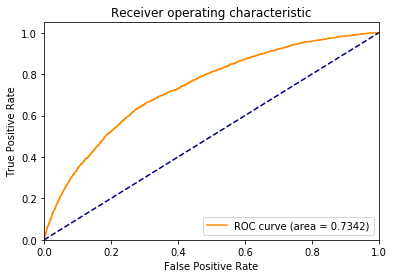

Confusion Matrix: 
 [[7590 3769]
 [1159 2482]]
Accuracy: 67.147%
Recall: 68.168%
Precision: 39.706%


In [25]:
#logistic regression performs best
#do grid search to tune hyperparameters

param_grid = {
    'clf__l1_ratio' :  np.linspace(0,1,25),
    }

metric = 'accuracy'

pipeline = make_pipline(cont_cols, cat_cols)
model = grid_search_train(X_train, y_train, pipeline, param_grid, metric = metric)
roc_stats(X_test, y_test, model)

In [26]:
#get coefficients
coefficients = get_coeff(model, cols)['coefficients'].reset_index()
coefficients

,features,coefficients
0,city_King's Landing,1.260221
1,phone_iPhone,0.981353
2,city_Winterfell,0.533947
3,trips_in_first_30_days,0.401481
4,ultimate_black_user,0.311576
5,avg_dist,-0.248794
6,surge_pct,0.058153
7,avg_rating_by_driver,-0.030111
8,weekday_pct,-0.021369
9,avg_rating_of_driver,0.000000


## Conclusion

To improve rider retention, Ultimate should examine users who the model predicts will not be retained. In general, these are users from Astapor, using Android, taking fewer trips in first 30 dats, and do not use the ultimate black service.  There are many ways to explore improving user retention given this information:
1. <b>Improve Android Issues</b>- Android users are much less likely to be retained compared to iPhone users, suggesting there may be usability issues on Android
2. <b>Incentives for Astapor users</b> - Astapor users are much less likely to be retained compared to users from other cities.  Perhaps it is less convenient to use Ultimate's service for Astapor users. This may be for a variety of reasons, lack of drivers in the area, cost is prohibitive for socioeconomic situation of Astapor users, better alternatives or competitors in Astapor area. To improve retention among Astapor users, we may need to include additional incentives for these users or increase ease of use for them (ie: increase supply of drivers in their area).
3. <b>Increase usage in first month</b> - Users with fewer trips in the first 30 days are less likely to be retained, indicating that early habits are indicative of longterm retention.  Incentives to get new users in the habit of using Ultimate could increase retention (ie: new user promotions or gamification).  Similarly users who do not use Ultimate Black service are less likely to be retained.  This could be an indicator that users who are interested in the deluxe experience are more likely to keep using Ultimate.  However, it could also suggest that users who try the Ultimate Black service will enjoy it and stick with the service.  In that case, it may be worthwhile to get new users to try the Ultimate Black service to see if it improves retention.
